In [72]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image

### load the npz file and create the array to be then used for model training and testing

In [73]:
with np.load('images_data.npz', allow_pickle=True) as npz_file:
    df = pd.DataFrame(npz_file['values'], columns= npz_file['columns'])
    
df_train = df[df['imageSet'] == 'train']
df_test = df[df['imageSet'] == 'test']

X_tr = df_train.drop(['imageSet','category','imageFileName'], axis=1).values
X_tr = np.float32(X_tr)

X_te = df_test.drop(['imageSet','category','imageFileName'], axis=1).values
X_te = np.float32(X_te)

features_names=df_train.drop(['imageSet','category','imageFileName'], axis=1).columns
categories = ['bike', 'car', 'motorcycle','other','truck','van']

### transform the categories into numerical values to be then used for logistic regression

In [74]:
def cat2num(x):
    if x == 'bike':
        return 0
    if x=='car':
        return 1
    if x =='motorcycle':
        return 2
    if x == 'other':
        return 3
    if x =='truck':
        return 4
    if x =='van':
        return 5
df_train['category_num'] = df_train['category'].apply(cat2num)
df_test['category_num'] = df_test['category'].apply(cat2num)
y_tr = df_train.category_num.values
y_te = df_test.category_num.values

C:\Users\lmbhoc2\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lmbhoc2\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### fit a multi-class logistic regression with OvR:
- let's create a pip with a first step as standscaler

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=1, multi_class='ovr', solver='liblinear', random_state=0))
])

pipe.fit(X_tr, y_tr)

accuracy = pipe.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.920


- we obtain an accuracy of 92% without tuning the strength parameter

### Apply a gridsearchCV to improve results of our logistic regression:
- shuffle the data to improve (maybe) the results...

In [76]:
from sklearn.utils import shuffle
X_tr_s, y_tr_s = shuffle(X_tr, y_tr)

In [77]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=0))
])
grid = {'logreg__C': np.linspace(0.0001, 1000, 10)}
grid_cv = GridSearchCV(pipe, grid, cv=5, return_train_score=True)

grid_cv.fit(X_tr_s, y_tr_s)

C:\Users\lmbhoc2\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': array([1.00000e-04, 1.11111e+02, 2.22222e+02, 3.33333e+02, 4.44445e+02,
       5.55556e+02, 6.66667e+02, 7.77778e+02, 8.88889e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [78]:
cv_results = pd.DataFrame(grid_cv.cv_results_)

cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_logreg__C']
cv_results[cols].sort_values('mean_test_score', ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logreg__C
5,0.903571,0.023703,1.000000,0.000000,555.556
1,0.900000,0.031822,1.000000,0.000000,111.111
2,0.900000,0.031822,1.000000,0.000000,222.222
4,0.900000,0.028885,1.000000,0.000000,444.445
6,0.900000,0.017980,1.000000,0.000000,666.667
9,0.900000,0.017980,1.000000,0.000000,1000
3,0.896429,0.037276,1.000000,0.000000,333.333
7,0.896429,0.023880,1.000000,0.000000,777.778
8,0.896429,0.023880,1.000000,0.000000,888.889
0,0.882143,0.045709,0.941108,0.010535,0.0001


In [79]:
grid_cv.score(X_te, y_te)

0.94

- I get  94% accuracy with cross validation.

In [80]:
ind = np.random.choice(len(X_tr)-1, 10)

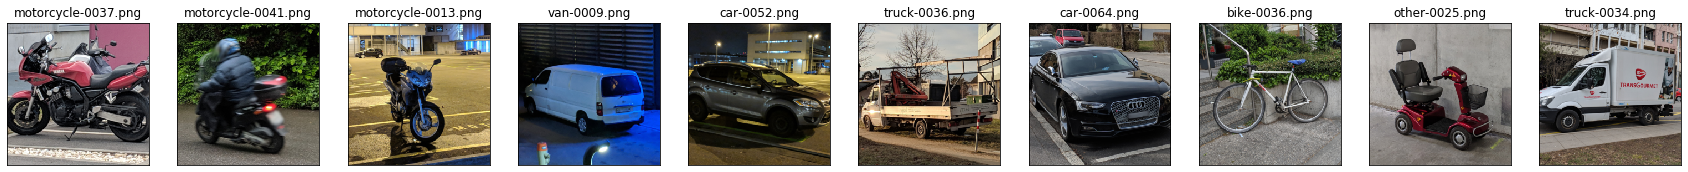

In [85]:
proba_results = []

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 30))

# Plot the 10 nearest images 
for i, axis in enumerate(axes.flatten()):
    img = Image.open(df_train['imageFileName'].iloc[ind[i]])
    title = df_train['imageFileName'].iloc[ind[i]].split('\\')[1]
    axis.set_title(title)
    proba = grid_cv.predict_proba(X_tr[ind[i]].reshape(1,-1))
    
    proba_results.append({
            'name': title,
            'bike': proba[0][0],
            'car': proba[0][1],
            'motorcycle': proba[0][2],
            'other': proba[0][3],
            'truck': proba[0][4],
            'van': proba [0][5]       
    })
        

    # Plot kernel with imshow()    
    axis.imshow(img)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    
plt.show()

In [86]:
# Convert results to DataFrame
proba_results = pd.DataFrame(proba_results)
proba_results.set_index('name', inplace=True)
proba_results.round(2)

,bike,car,motorcycle,other,truck,van
name,,,,,,
motorcycle-0037.png,0.0,0.0,1.0,0.0,0.0,0.0
motorcycle-0041.png,0.0,0.0,1.0,0.0,0.0,0.0
motorcycle-0013.png,0.0,0.0,1.0,0.0,0.0,0.0
van-0009.png,0.0,0.0,0.0,0.0,0.0,1.0
car-0052.png,0.0,1.0,0.0,0.0,0.0,0.0
truck-0036.png,0.0,0.0,0.0,0.0,1.0,0.0
car-0064.png,0.0,1.0,0.0,0.0,0.0,0.0
bike-0036.png,1.0,0.0,0.0,0.0,0.0,0.0
other-0025.png,0.0,0.0,0.0,1.0,0.0,0.0


- the logistic regression is giving the higher probability to the corrisponding category for our 10 exemples
- the more we increase the regularization strength the highest is the probability of the corrisponding category until it reaches 1.
- the more we decrease the regularization strength the less the probability prediction is "stark" identified
- this is due to the sigmoid function which associate large  positive and negative values with probabilities close to respectively 1 and 0 and 0.5 for x=0
    - indeed increasing C, reduces penaliation and therefore large coefficients will lead to probabilities close to 1 or 0
    - on the contrary decreasing C increases the penalization and therefore the sigmoid value, probability will converge toward 1/6

In [69]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=0.0001, multi_class='ovr', solver='liblinear', random_state=0))
])
pipe.fit(X_tr_s,y_tr_s)
pipe.score(X_te,y_te)

0.96